# Preparação do ambiente

## Conexão com o drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importanto libs

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math

# Código fonte

Lendo a base

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Di2Win/"+
"Alura_2023/Machine Learning para Negócios Digitais/" + 
"Clusterização de dados: Segmentação de clientes/BancoDeDados.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amostra               116581 non-null  int64  
 1   id_cliente            116581 non-null  object 
 2   id_unico_cliente      116581 non-null  object 
 3   item_id               116581 non-null  int64  
 4   cep_cliente           116581 non-null  int64  
 5   cidade_cliente        116581 non-null  object 
 6   estado_cliente        116581 non-null  object 
 7   id_pedido             116581 non-null  object 
 8   status_pedido         116581 non-null  object 
 9   horario_pedido        116581 non-null  object 
 10  pedido_aprovado       116567 non-null  object 
 11  pedido_entregador     115368 non-null  object 
 12  pedido_entregue       114066 non-null  object 
 13  data_estimada         116581 non-null  object 
 14  id_vendedor           116581 non-null  object 
 15  

## 1. Introdução ao problema

In [75]:
def plot_perc(st, dados):
  plt.figure(figsize=(20,8))

  g = sns.countplot(x=st, data=dados, orient='h')
  g.set_ylabel('Contagem', fontsize=17)

  sizes = []
  for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x() + p.get_width()/1.6, 
           height+200,
           '{:1.2f}%'.format(height/116581*100),
           ha = 'center',
           va='bottom',
           fontsize=12)
    
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
  
  g.set_ylim(0, max(sizes)*1.1)

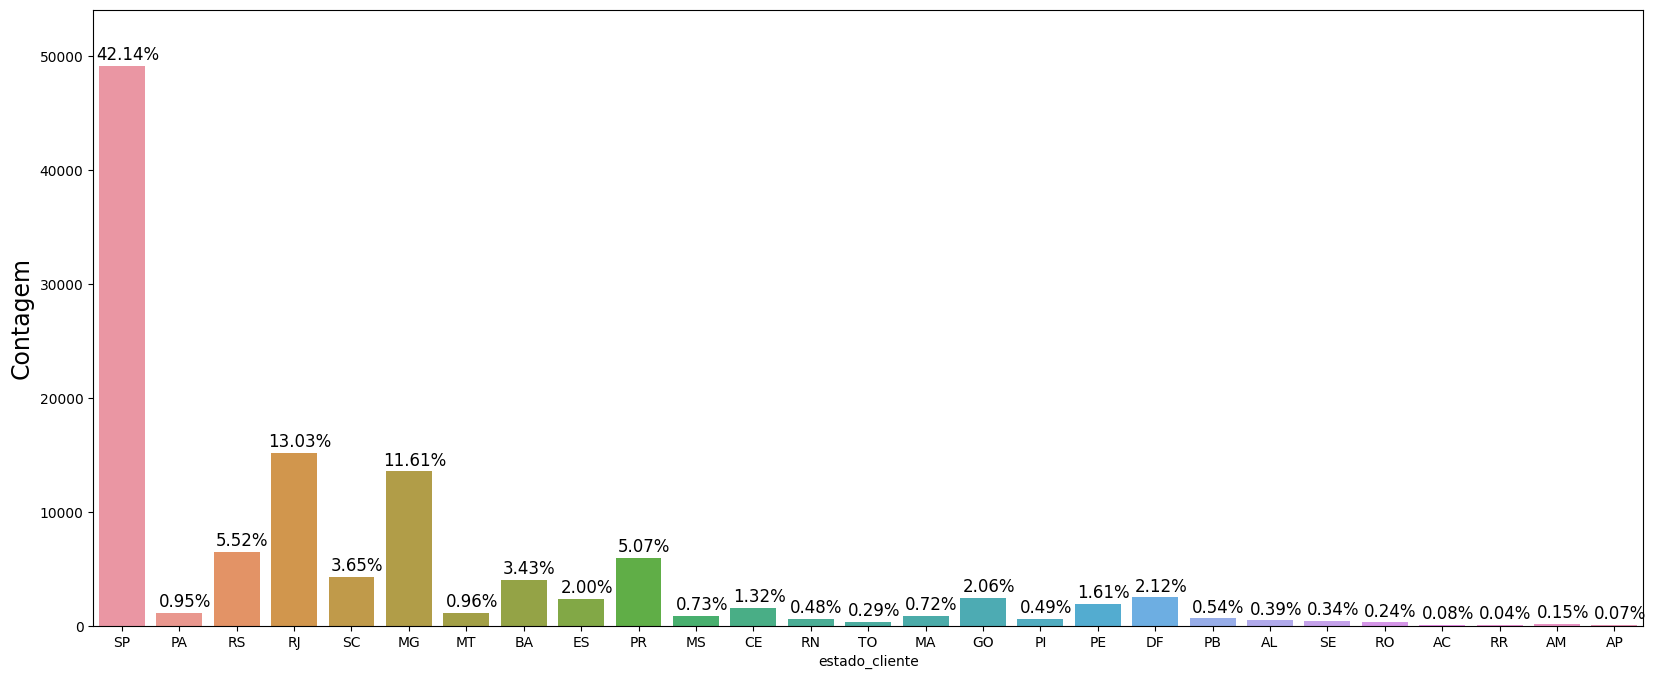

In [ ]:
# Analisar os estados com maior percentual de clientes
plot_perc('estado_cliente', df)

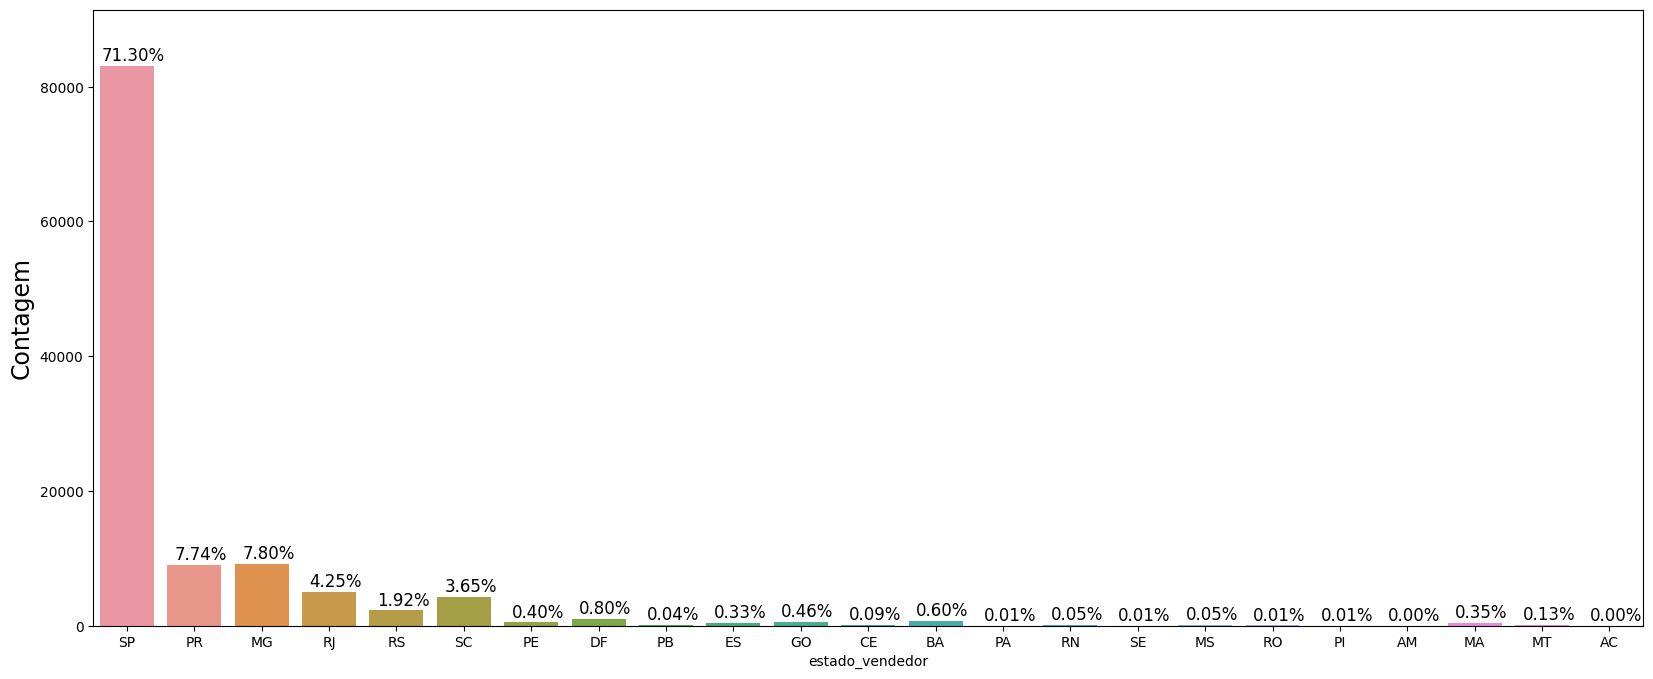

In [ ]:
# Estado com maior percentual de vendedores
plot_perc('estado_vendedor', df)

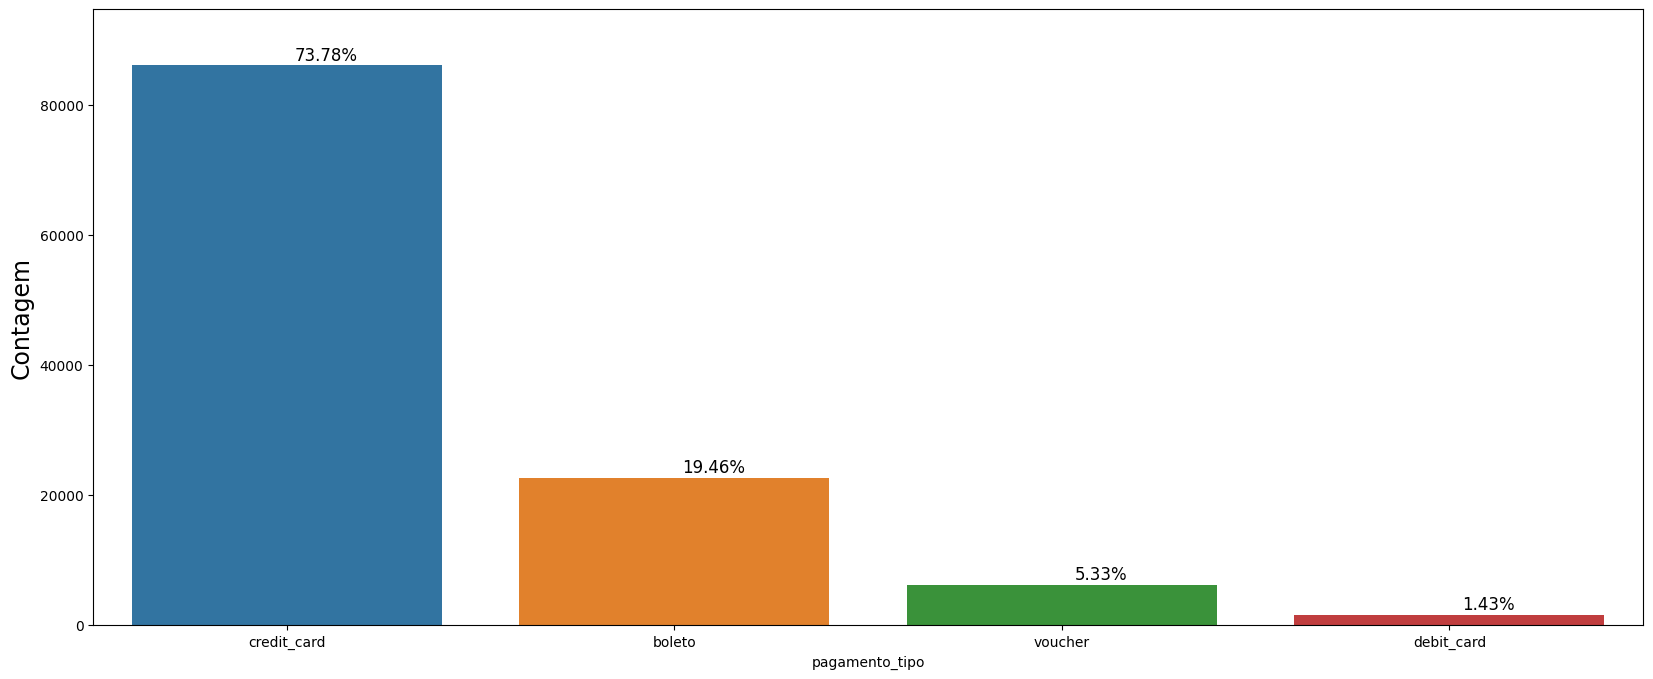

In [ ]:
# Analisar o tipo de pagamento
plot_perc('pagamento_tipo', df)

Avaliando quais são os estados com maior valor de compra

Text(0, 0.5, 'Preço')

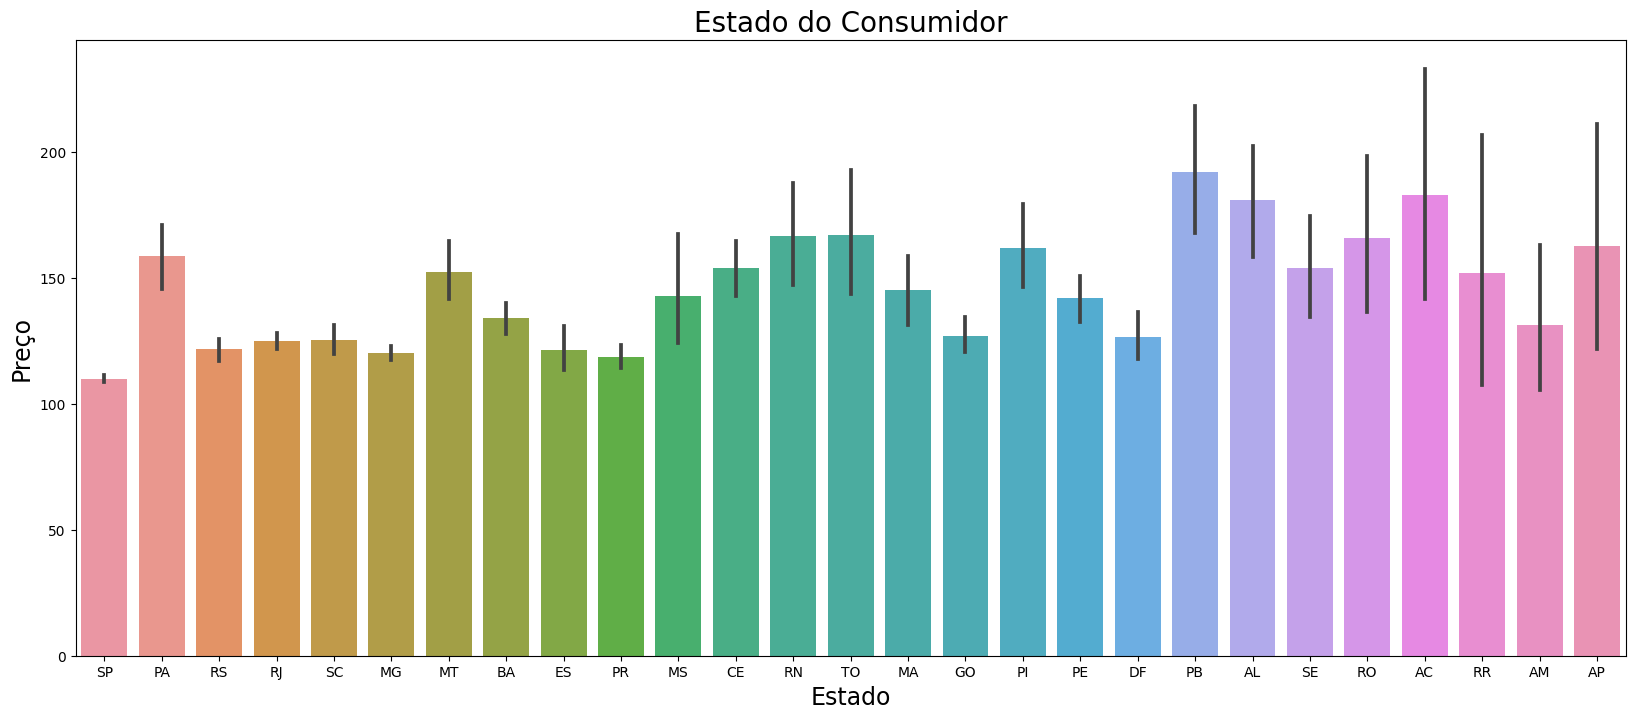

In [ ]:
plt.figure(figsize=(20,8))
g2 = sns.barplot(x='estado_cliente', y='preco',
                 data=df[df['preco'] != -1])
g2.set_title("Estado do Consumidor", fontsize=20)
g2.set_xlabel("Estado", fontsize=17)
g2.set_ylabel("Preço", fontsize=17)
# g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

Avaliando quais são os estados com maior valor de frete

Text(0, 0.5, 'Frete')

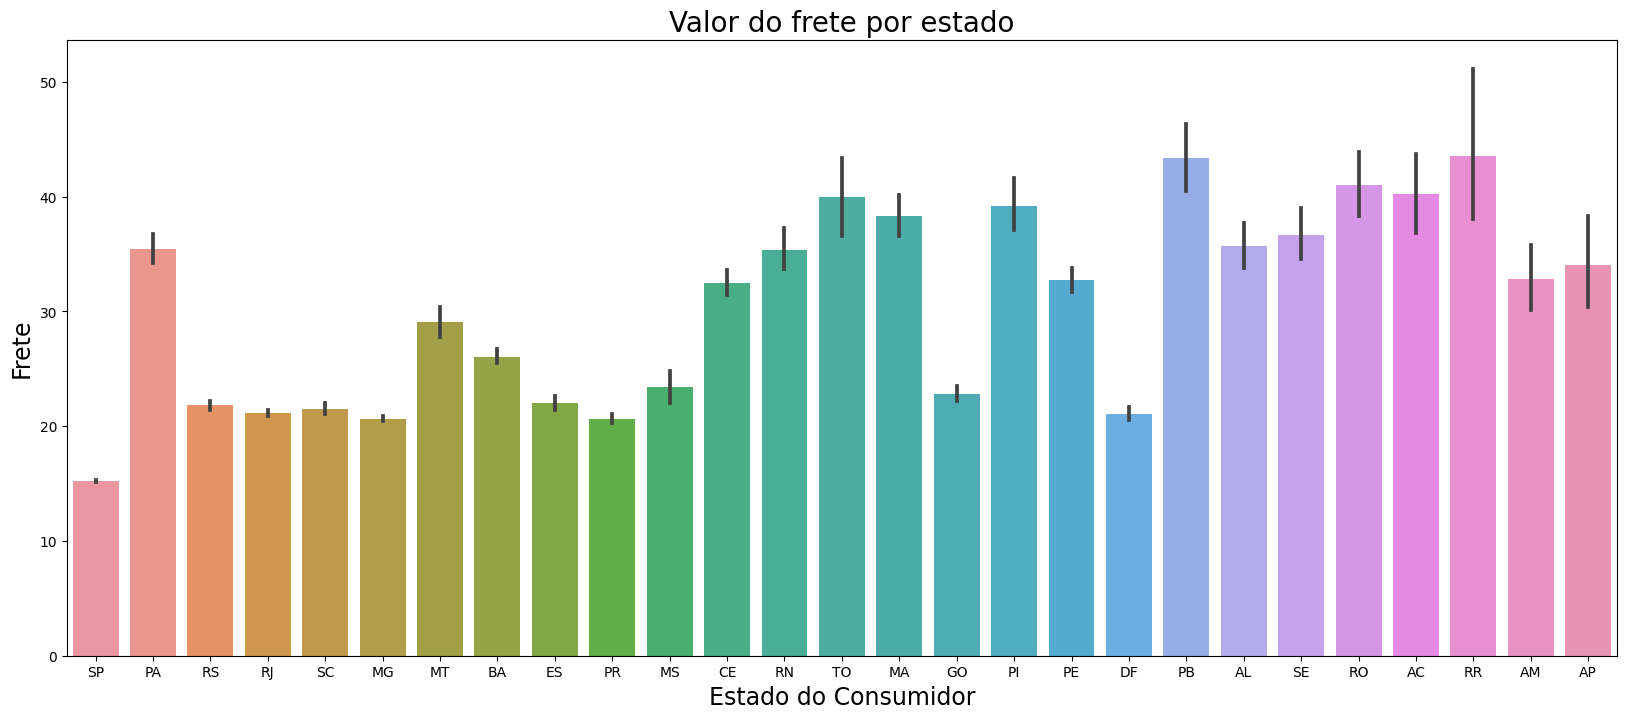

In [ ]:
plt.figure(figsize=(20,8))
g3 = sns.barplot(x='estado_cliente', y='frete',
                 data=df[df['preco'] != -1])
g3.set_title("Valor do frete por estado", fontsize=20)
g3.set_xlabel("Estado do Consumidor", fontsize=17)
g3.set_ylabel("Frete", fontsize=17)
# g3.set_xticklabels(g3.get_xticklabels(),rotation=45)

Criando mapa de calor para os estados e suas regiões

In [ ]:
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

In [ ]:
df.loc[df['estado_cliente'].isin(sudeste), 'Regiao'] = 'Sudeste'
df.loc[df['estado_cliente'].isin(nordeste), 'Regiao'] = 'Nordeste'
df.loc[df['estado_cliente'].isin(norte), 'Regiao'] = 'Norte'
df.loc[df['estado_cliente'].isin(centro_oeste), 'Regiao'] = 'Centro_Oeste'
df.loc[df['estado_cliente'].isin(sul), 'Regiao'] = 'Sul'

<Axes: xlabel='estado_cliente', ylabel='Regiao'>

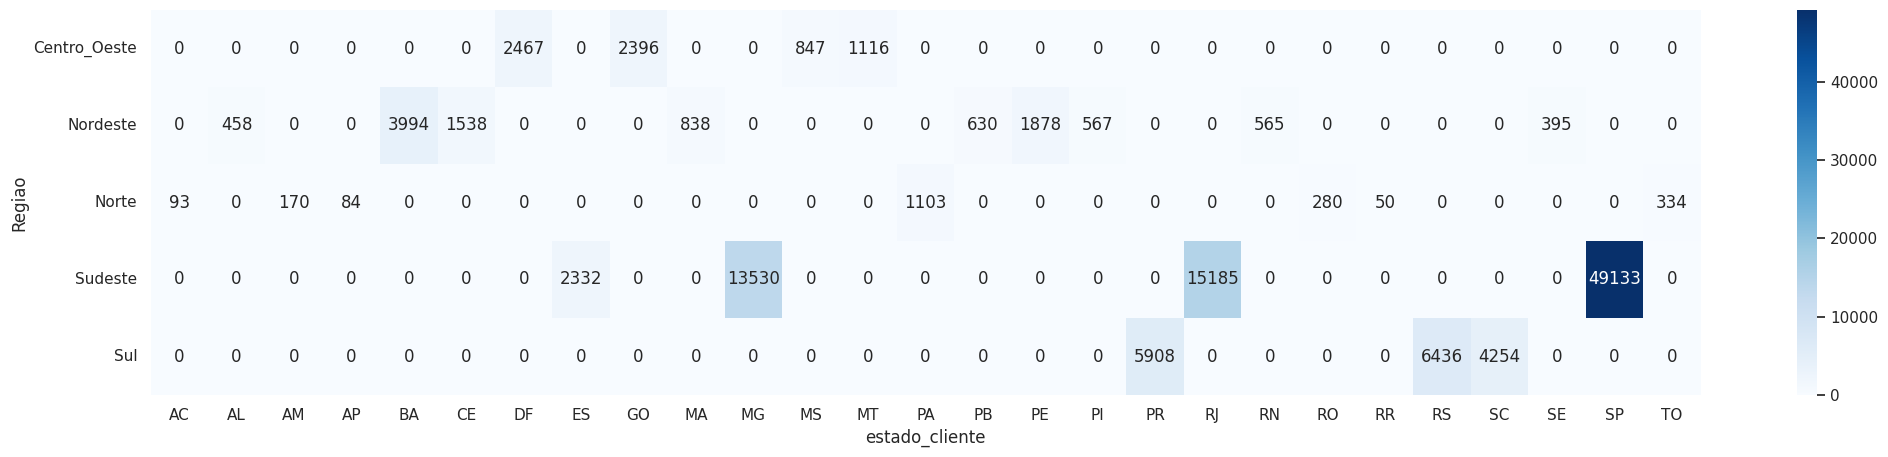

In [ ]:
# Calcular a frequência dos valores das variáveis 'Regiao' e 'estado_cliente'
frequencia = pd.crosstab(index=df['Regiao'], columns=df['estado_cliente'])

# Ajustar o tamanho do gráfico
sns.set(rc={'figure.figsize':(25,5)})

# Plotar o mapa de calor com o Seaborn
sns.heatmap(frequencia, cmap='Blues', annot=True, fmt='d')

## 2. Clusterização em marketing digital

**Modelo RFM**


---


**R** - *Recência*


Há quanto tempo/dias foi a última compra do cliente?

**F** - *Frequência*

Quantas compras esse cliente já fez na sua empresa, desde que se cadastrou?

**M** - *Monetaridade*

Quanto esse cliente já gastou em dinheiro na sua empresa?


Seguindo o modelo RFM, podemos criar um banco somente com as informações que
irão ser úteis pra essa modelagem.

### Recência

In [5]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id',
               'preco']]

In [6]:
df_olist.head(5)

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99


In [7]:
# Criar coluna com data de compra mais recente de cada cliente
df_compra = df.groupby('id_unico_cliente').horario_pedido.max().reset_index()
df_compra.columns = ['id_unico_cliente', 'data_max_compra']

# Converter a data para o formato datetime
df_compra['data_max_compra'] = pd.to_datetime(df_compra['data_max_compra'])

In [8]:
# Crianco a RECÊNCIA como a subtração de dias entre a compra mais recente do banco com a do cliente
df_compra['Recencia'] = (df_compra['data_max_compra'].max() - df_compra['data_max_compra']).dt.days

In [9]:
df_compra.head()

,id_unico_cliente,data_max_compra,Recencia
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


In [10]:
# Uninco os dois dataframes
df_usuarios = pd.merge(df_olist, df_compra[['id_unico_cliente', 'Recencia']], 
                       on='id_unico_cliente')

In [11]:
df_usuarios.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211


### Aplicando a regra do cotovelo

In [12]:
def calcular_wcss(data):
  wcss = []
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X=data),
    data['Clusters'] = kmeans.labels_
    wcss.append(kmeans.inertia_)
  return wcss

In [13]:
df_recencia = df_usuarios[['Recencia']]
df_recencia.head()

,Recencia
0,474
1,298
2,298
3,483
4,211


In [14]:
soma_quadrados = calcular_wcss(df_recencia)

<ipython-input-12-271d0043e86a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Clusters'] = kmeans.labels_
<ipython-input-12-271d0043e86a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Clusters'] = kmeans.labels_
<ipython-input-12-271d0043e86a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

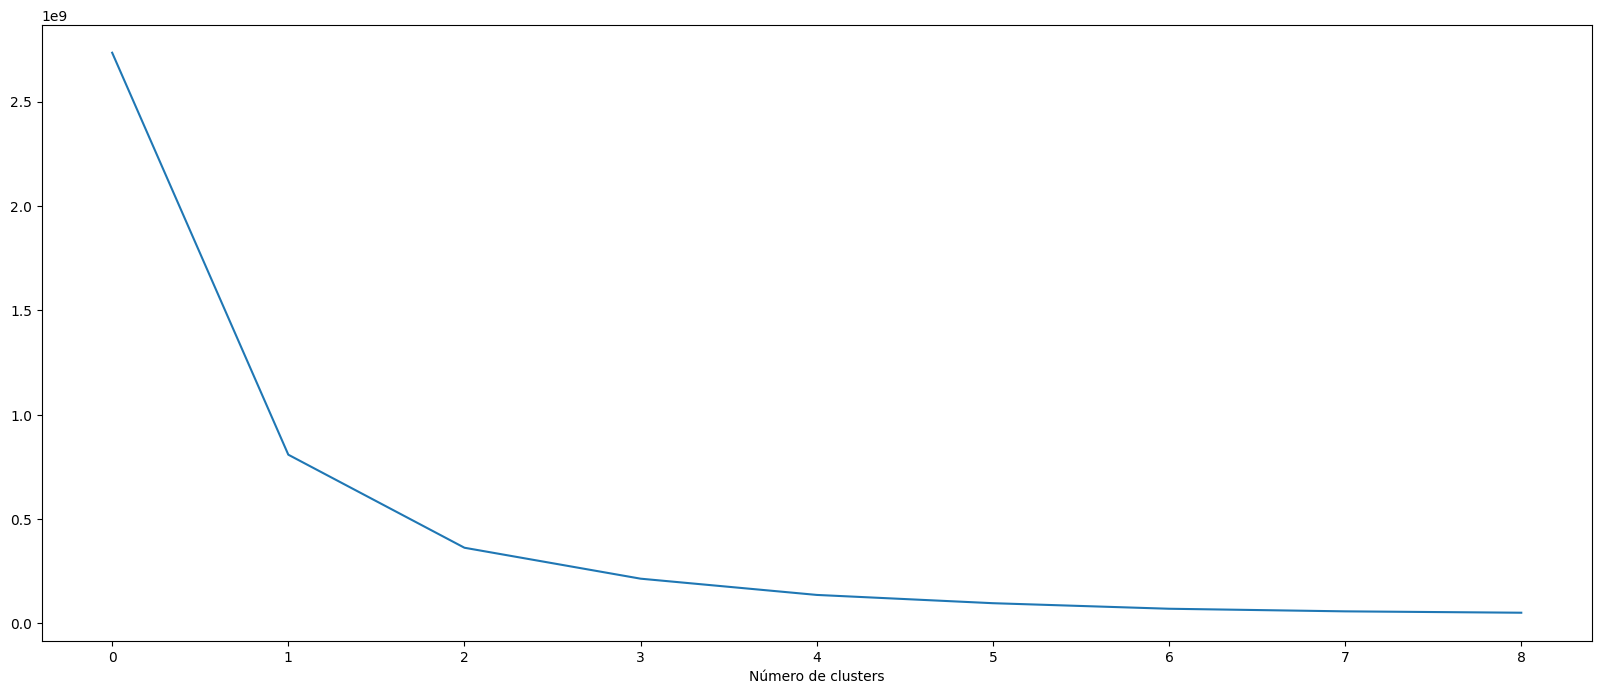

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(soma_quadrados)
plt.xlabel('Número de clusters')
plt.show()

Avaliando o gráfico, um valor de 3 ou 4 clusters teria um bom resultado. 

Entretando, existe um método matemático para fazer a verificação...

De modo que, o ponto que indica o equilíbrio entre maior homogeneirdade dentro do cluster e menor diferença entre clusters é o ponto mais distante da reta traçada entre o inicial e o final.

In [15]:
def nummero_otimo_clusters(wcss):
  x1, y1 = 2, wcss[0]
  x2, y2 = 20, wcss[len(wcss)-1]

  distancia = []
  for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerador = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    denominador = math.sqrt((y2-y1)**2 + (x2-x1)**2)
    distancia.append(numerador/denominador)
  return distancia.index(max(distancia)) + 2

In [16]:
n = nummero_otimo_clusters(soma_quadrados)
print('N: ' + str(n))

N: 4


## 3.  Clusterizando o modelo RFM

In [17]:
kmeans = KMeans(n_clusters=4)
df_usuarios['RecenciaCluster'] = kmeans.fit_predict(df_recencia)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
df_usuarios.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298,1
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298,1
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211,0


In [19]:
# Media das recências por clusters
agrupado_por_cluster = df_usuarios.groupby('RecenciaCluster')['Recencia'].mean().reset_index()
agrupado_por_cluster.head()

,RecenciaCluster,Recencia
0,0,187.911204
1,1,320.233294
2,2,66.790878
3,3,490.622269


In [20]:
# Ordenando o agrupamento por recência
agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by='Recencia', ascending=False).reset_index(drop=True)
agrupado_por_cluster_ordenado.head()

,RecenciaCluster,Recencia
0,3,490.622269
1,1,320.233294
2,0,187.911204
3,2,66.790878


In [21]:
agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
agrupado_por_cluster_ordenado.head()

,RecenciaCluster,Recencia,index
0,3,490.622269,0
1,1,320.233294,1
2,0,187.911204,2
3,2,66.790878,3


In [22]:
juntando_cluster = pd.merge(df_usuarios, agrupado_por_cluster_ordenado[['RecenciaCluster', 'index']], on='RecenciaCluster')
juntando_cluster.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,3,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,3,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,3,0


In [23]:
# Removendo a coluna de RecenciaCluster, pois o index vai servir como novo grupo
removendo_dados = juntando_cluster.drop(['RecenciaCluster'], axis=1)
removendo_dados.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [24]:
df_final = removendo_dados.rename(columns={'index': 'RecenciaCluster'})
df_final.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


Criando função para o ordenamento dos clusters:

In [25]:
def ordenador_cluster(cluster_nome, target_nome, df, to_ascend=False):
  agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
  agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome, ascending=to_ascend).reset_index(drop=True)
  agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
  juntando_cluster = pd.merge(df, agrupado_por_cluster_ordenado[[cluster_nome, 'index']], on=cluster_nome)
  removendo_dados = juntando_cluster.drop([cluster_nome], axis=1)
  df_final = removendo_dados.rename(columns={'index': cluster_nome})
  return df_final

In [26]:
df_usuarios = ordenador_cluster('RecenciaCluster', 'Recencia', df_usuarios)
df_usuarios.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


### Frequência

In [27]:
df_frequencia = df.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente', 'Frequencia']
df_frequencia.head()

,id_unico_cliente,Frequencia
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [28]:
df_usuarios = pd.merge(df_usuarios, df_frequencia, on='id_unico_cliente')

In [29]:
df_frequencia = df_usuarios[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuarios['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)
df_usuarios.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,1


In [30]:
df_usuarios = ordenador_cluster('FrequenciaCluster', 'Frequencia', df_usuarios,
                                to_ascend=True)
df_usuarios.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0


In [31]:
df_usuarios.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,9205.0,5.644432,2.138491,4.0,4.0,5.0,6.0,13.0
2,731.0,21.489740,6.588977,14.0,15.0,21.0,24.0,38.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


### Receita

In [32]:
df_receita = df.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()
df_receita.columns = ['id_unico_cliente', 'Receita']
df_receita.head()

,id_unico_cliente,Receita
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [33]:
df_usuarios = pd.merge(df_usuarios, df_receita, on='id_unico_cliente')

In [34]:
df_receita = df_usuarios[['Receita']]
kmeans = KMeans(n_clusters=4)
df_usuarios['ReceitaCluster'] = kmeans.fit_predict(df_receita)
df_usuarios.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33,0


In [35]:
df_usuarios = ordenador_cluster('ReceitaCluster', 'Receita', df_usuarios,
                                to_ascend=True)
df_usuarios.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33,0


In [36]:
df_usuarios.groupby('ReceitaCluster')['Receita'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114904.0,261.485763,377.283592,9.59,69.90,132.82,270.00,3080.96
1,1478.0,5900.843911,2894.129234,3083.40,3798.75,4875.25,7315.92,16313.60
2,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


## 4. Criando uma pontuação para os clientes

In [77]:
# Criando dataframe somente com os dados uteis
df_final = df_usuarios[['id_unico_cliente', 
                        'Recencia', 'RecenciaCluster',
                        'Frequencia', 'FrequenciaCluster',
                        'Receita', 'ReceitaCluster']]
df_final.tail()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
116576,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116577,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116578,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116579,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116580,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3


In [78]:
df_final['Pontuacao'] = df_usuarios['RecenciaCluster'] + df_usuarios['FrequenciaCluster'] + df_usuarios['ReceitaCluster']
df_final.head()

<ipython-input-78-2e001a7c506d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Pontuacao'] = df_usuarios['RecenciaCluster'] + df_usuarios['FrequenciaCluster'] + df_usuarios['ReceitaCluster']


,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0


In [79]:
# Para clientes com pontuação específicas, criar categorias personalizados
df_final['Segmento'] = 'Inativo'
df_final.loc[df_final['Pontuacao'] == 0, 'Segmento'] = 'Inativo'
df_final.loc[df_final['Pontuacao'] >= 1, 'Segmento'] = 'Business'
df_final.loc[df_final['Pontuacao'] >= 3, 'Segmento'] = 'Master'
df_final.loc[df_final['Pontuacao'] >= 5, 'Segmento'] = 'Premium'

<ipython-input-79-a69b5b4d5172>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Segmento'] = 'Inativo'


In [64]:
df_final.tail()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao,Segmento
116576,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3,5,Premium
116577,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3,5,Premium
116578,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3,5,Premium
116579,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3,5,Premium
116580,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3,5,Premium


In [80]:
# Salvando dataframe
df_final.to_csv("/content/drive/MyDrive/Colab Notebooks/Di2Win/"+
"Alura_2023/Machine Learning para Negócios Digitais/" + 
"Clusterização de dados: Segmentação de clientes/RFM.csv")

### Análise de features

In [45]:
def plot_segmento(x, y, data):
  sns.set(palette='muted', color_codes=True, style='whitegrid')
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=x, y=y, hue='Segmento', data=data, size='Segmento',
                  sizes=(50,150), size_order=['Premium', 'Master', 'Business', 'Inativo'])
  plt.show()

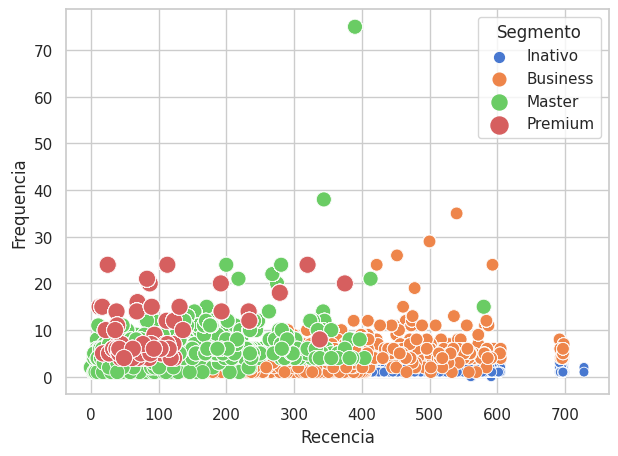

In [46]:
plot_segmento('Recencia', 'Frequencia', df_final)

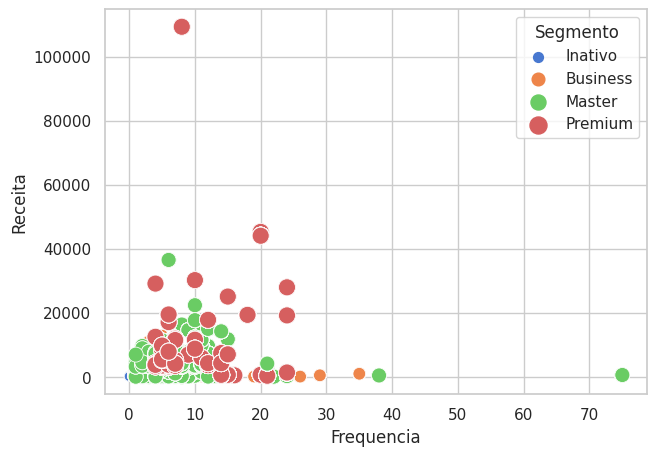

In [47]:
plot_segmento('Frequencia', 'Receita', df_final)

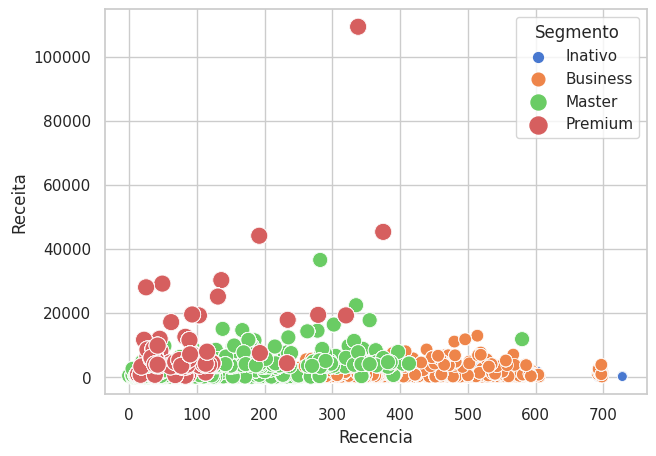

In [48]:
plot_segmento('Recencia', 'Receita', df_final)

<Axes: xlabel='Segmento', ylabel='count'>

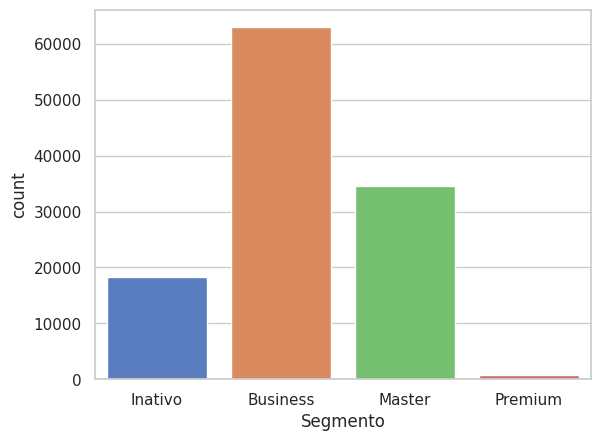

In [81]:
# Contar a quantidade de clientes em cada Segmento
sns.countplot(x=df_final['Segmento'])

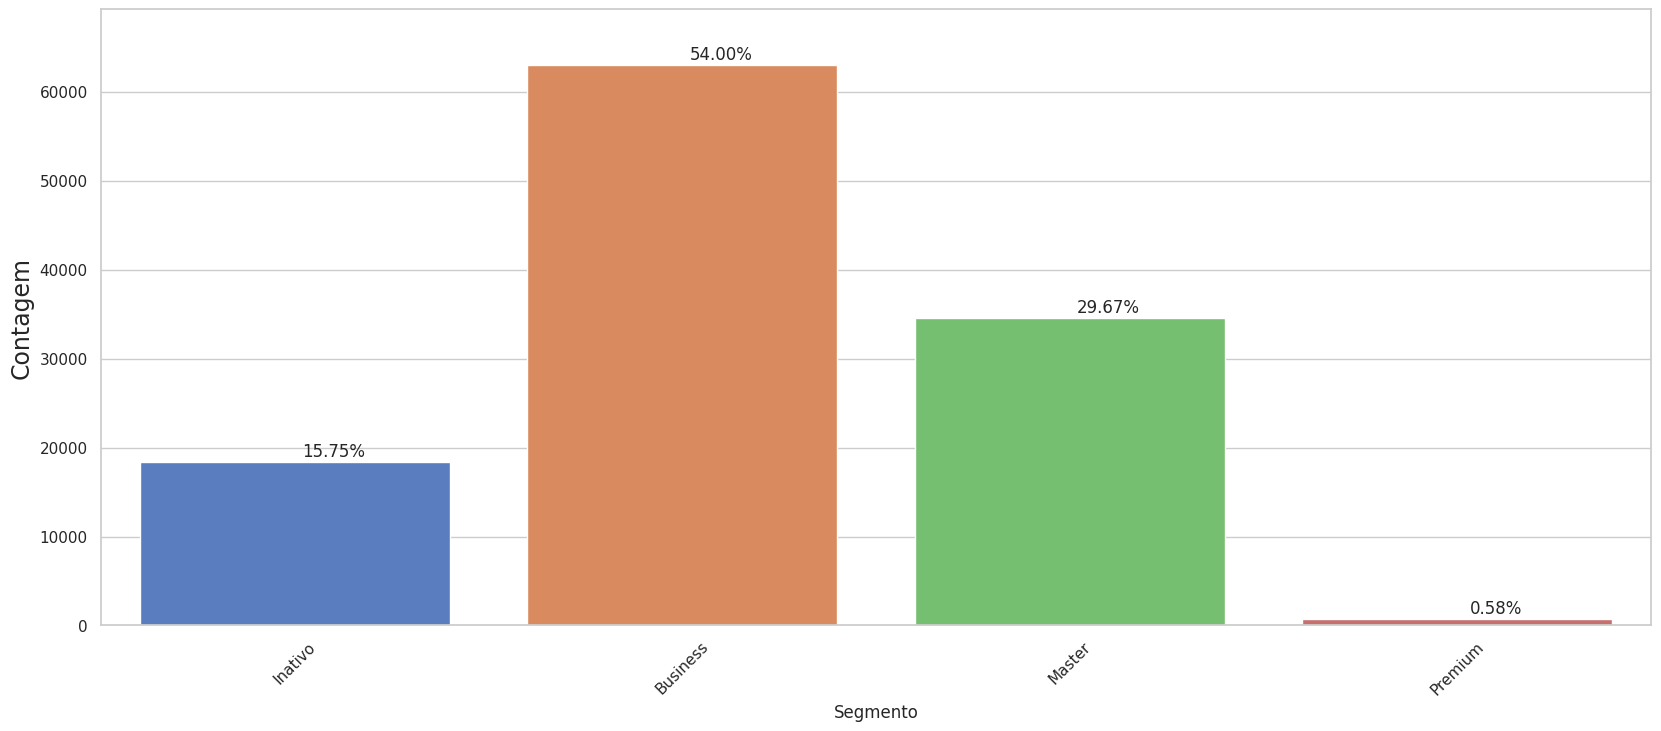

In [82]:
plot_perc('Segmento',df_final)

### Desafio: Criar novos grupos de clientes

In [69]:
df_final_2 = df_final.copy()

In [72]:
df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Campeao'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Fiel'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] = 'Potencialmente Fiel - Tipo 1'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Potencialmente Fiel - Tipo 2'

df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==0) & (df_final['ReceitaCluster']==0),'Segmento'] = 'Novos'

df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] = 'Promissores'

df_final.loc[(df_final['RecenciaCluster']==2) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] = 'Precisam Atencao'

df_final.loc[(df_final['RecenciaCluster']==2) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] ='Quase em Risco'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] ='Risco'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] ='Nao pode perder - Tipo 1'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] ='Hibernando'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==0) & (df_final['ReceitaCluster']==0),'Segmento'] ='Perdidos'

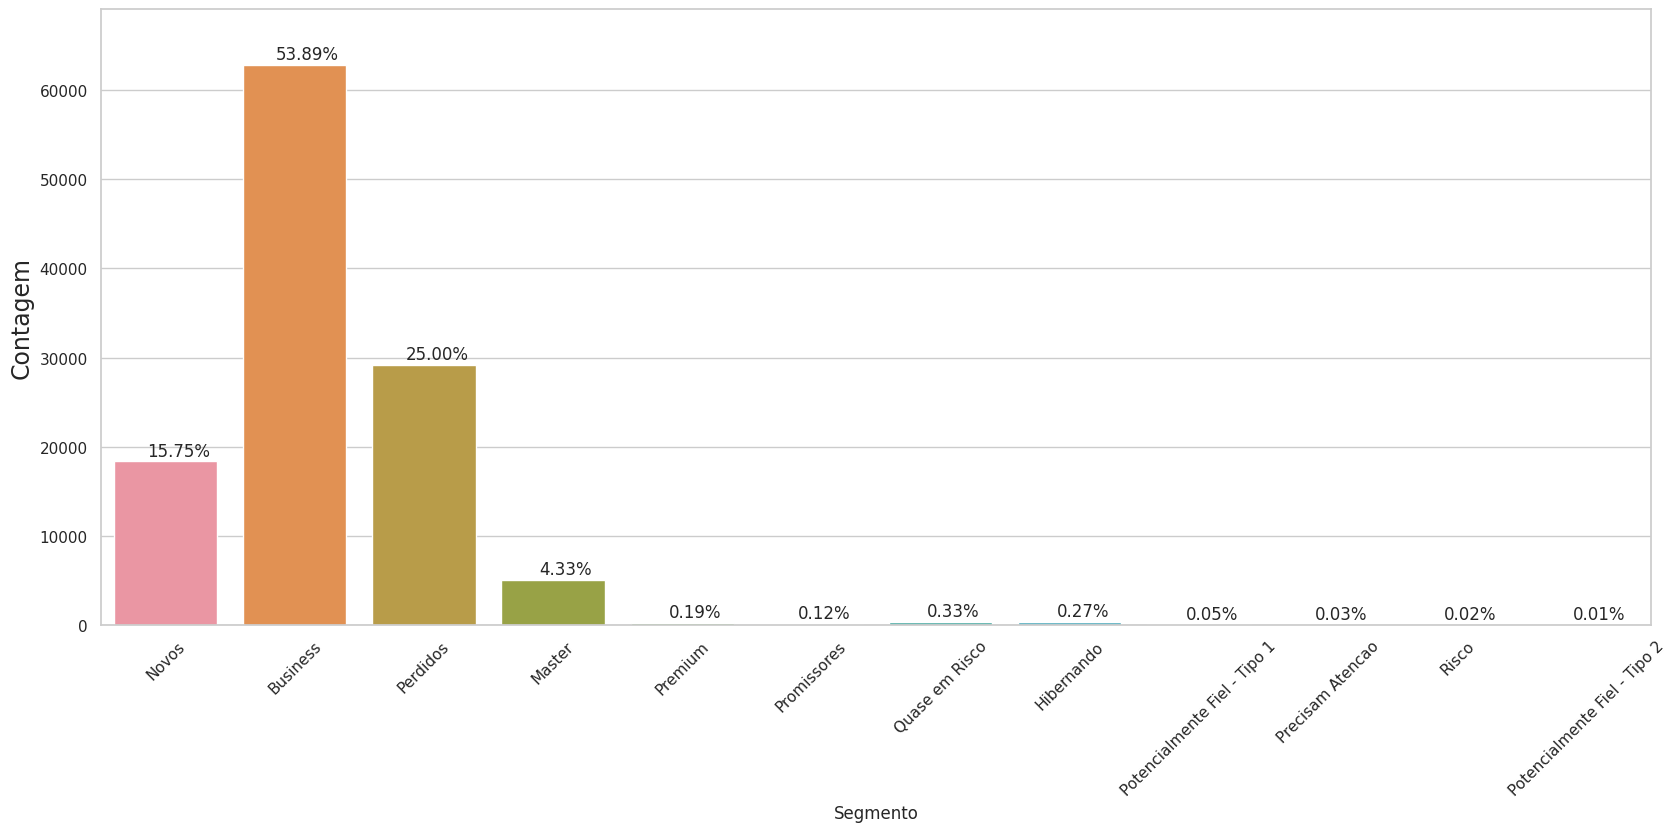

In [76]:
plot_perc('Segmento',df_final)